# Generate Dataset

## import Lib

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import random
from scipy.io.wavfile import write
import csv


RT60_MIN = 0
RT60_MAX = 0.7
ROOM_DIAMETER_RANGE_MIN = 1
ROOM_DIAMETER_RANGE_MAX = 5
MIC_NUM = 8
MIC_RADIUS = 0.1
SOURCE_NUM = 8
ROOM_LAYOUT_NUM = 10
FS = 44100



In [13]:
def location_3d_in_range(range_array, num_location, minimum=0):
    locations = []
    for _ in range(num_location):
        curr_loc = np.array([random.uniform(minimum, range_array[0]), random.uniform(minimum, range_array[1]), random.uniform(minimum, range_array[2])])
        locations.append(curr_loc)
        
    return locations

## Example Room

### Room Construction

[1.63984457 4.05881209 2.56190916]


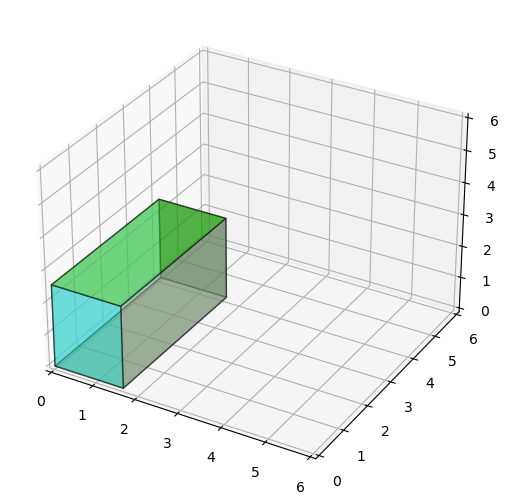

In [15]:
room_dim =  np.array([random.uniform(ROOM_DIAMETER_RANGE_MIN, ROOM_DIAMETER_RANGE_MAX) for _ in range(3)])

e_absorption, max_order = pra.inverse_sabine(random.uniform(RT60_MIN, RT60_MAX), room_dim)

# Create the room
room = pra.ShoeBox(
    room_dim, fs=FS, materials=pra.Material(e_absorption), max_order=max_order
)


print(room_dim)
fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

In [16]:
print(room.shoebox_dim)
print(room.mic_array)

[1.6398445 4.058812  2.5619092]
None


### Add Mic Array

mic position: 
 [[1.28323909 1.74054891 2.32910754]
 [1.25394976 1.81125958 2.32910754]
 [1.18323909 1.84054891 2.32910754]
 [1.11252841 1.81125958 2.32910754]
 [1.08323909 1.74054891 2.32910754]
 [1.11252841 1.66983823 2.32910754]
 [1.18323909 1.64054891 2.32910754]
 [1.25394976 1.66983823 2.32910754]]


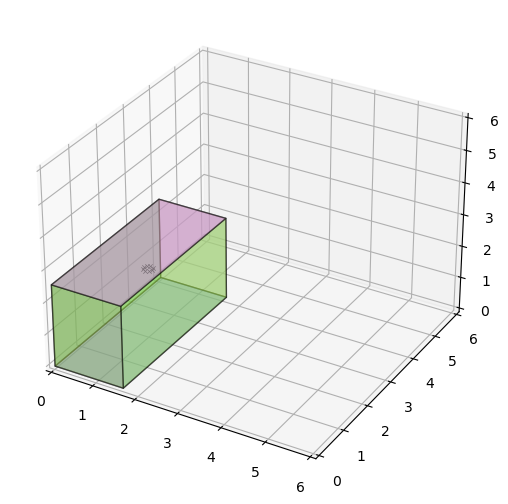

In [17]:
mic_center =  location_3d_in_range(room_dim, 1, minimum=MIC_RADIUS)[0]

R = pra.circular_2D_array(center=mic_center[:2], M=MIC_NUM, phi0=0, radius=MIC_RADIUS)
R = np.concatenate((R, np.ones((1, MIC_NUM)) * mic_center[2]), axis=0)
mics = pra.MicrophoneArray(R, FS)
room.add_microphone_array(mics)


fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6])

print("mic position: \n", R.T)

### Add Source

In [18]:
# fs, signal_1 = wavfile.read("source_1.wav")
# fs, signal_2 = wavfile.read("source_2.wav")
# signal_1 = signal_1[:44100]
# signal_2 = signal_2[:44100]
# print(signal_2.shape)

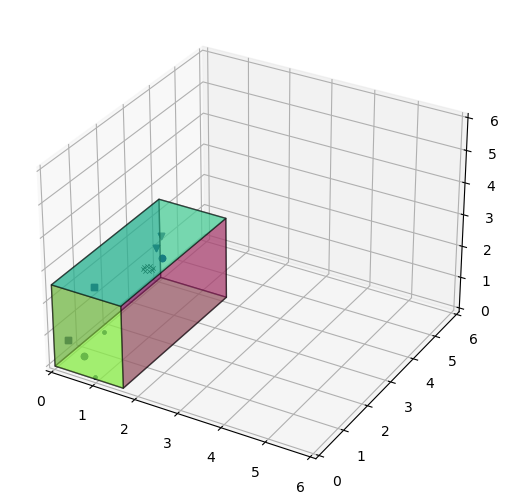

In [19]:
source_locations = location_3d_in_range(room_dim, SOURCE_NUM, minimum=0)

for i in range(SOURCE_NUM):
    room.add_source(source_locations[i], delay=0)


fig, ax = room.plot()
ax.set_xlim([0, 6])
ax.set_ylim([0, 6])
ax.set_zlim([0, 6]);

In [20]:
# print(room.sources)
# del room.sources[0]
# print(room.sources)

# print(room.mic_array)
# room.mic_array = None
# print(room.mic_array)

# fig, ax = room.plot()
# ax.set_xlim([0, 6])
# ax.set_ylim([0, 6])
# ax.set_zlim([0, 6]);

In [20]:
source_locations = [source.position for source in room.sources]
print(type(source_locations))

<class 'list'>


### Compute Room RIR

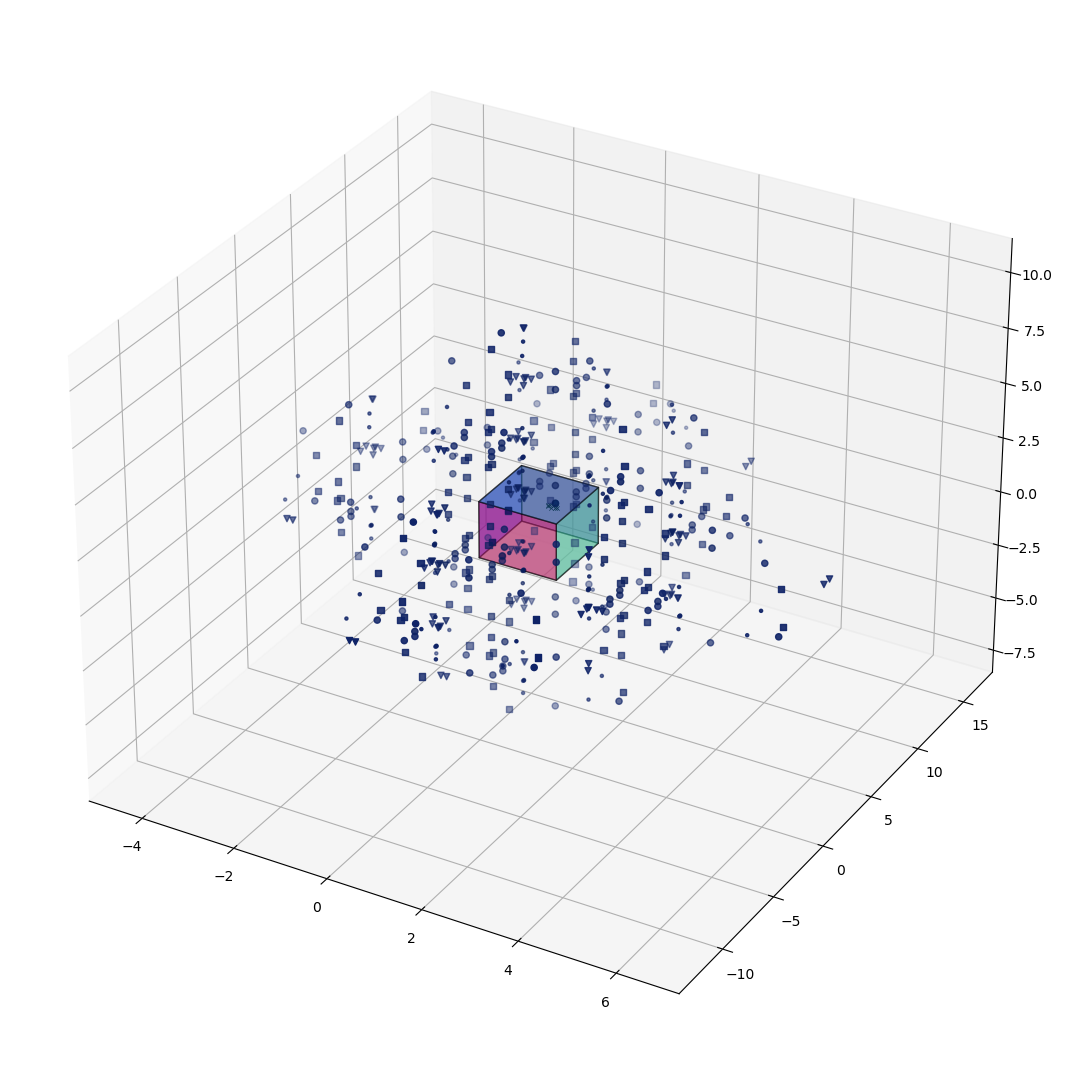

In [21]:
# compute image sources
# room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
room.image_source_model()

# visualize 3D polyhedron room and image sources
fig, ax = room.plot(img_order=3)
fig.set_size_inches(18.5, 10.5)

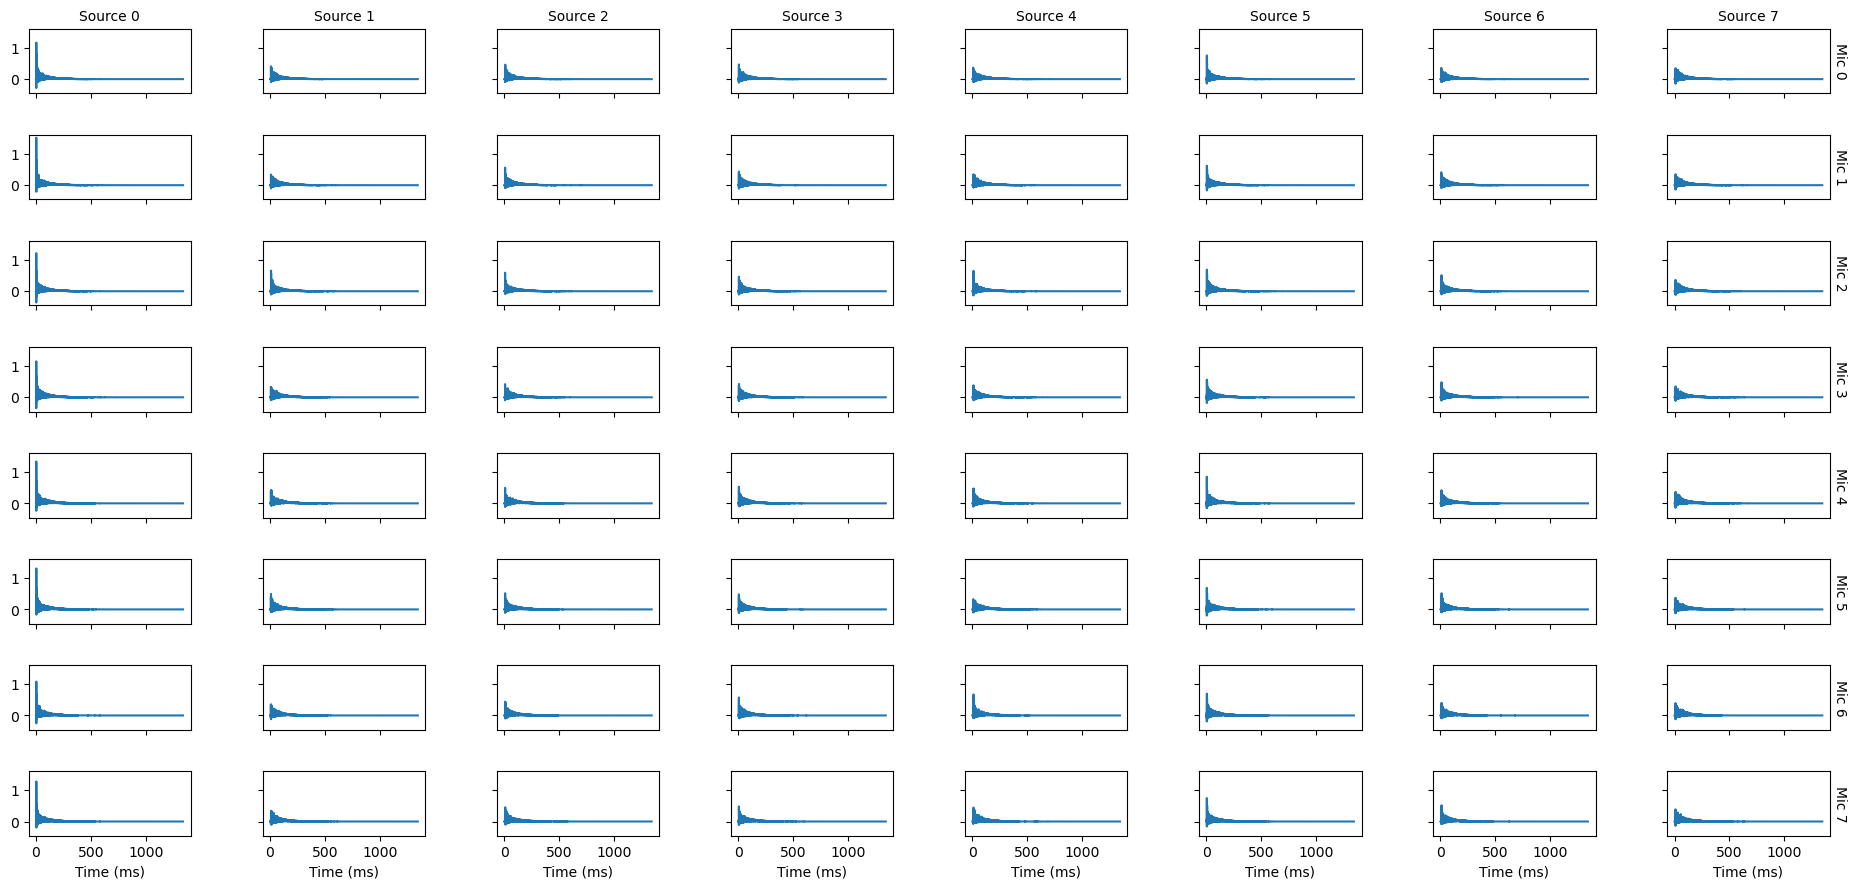

In [22]:
room.compute_rir()
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

The RT60 is 100 ms


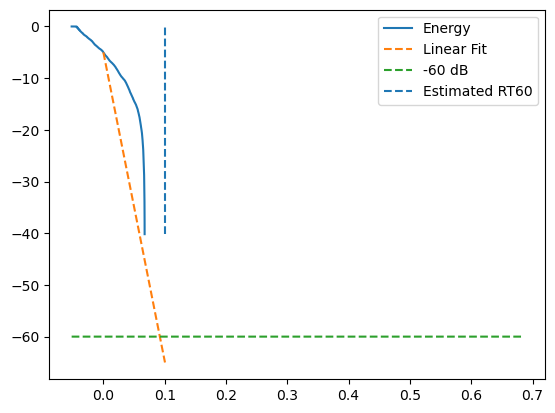

In [10]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [14]:
# room.simulate()


# # original signal
# print("Original WAV:")
# IPython.display.Audio(signal_1, rate=fs)



In [15]:

# # original signal
# print("Original WAV:")
# IPython.display.Audio(signal_2, rate=fs)

In [16]:

# print("Simulated propagation to first mic:")
# # print(room.mic_array.signals.shape)
# IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

In [23]:
def truncate_rir(room_rir, num_source, num_mic):
    rir_len_lst = []
    for i in range(num_mic):
        for j in range(num_source):
            rir_len_lst.append(len(room_rir[i][j]))
            
    min_rir_len = min(rir_len_lst)
    for i in range(num_mic):
        for j in range(num_source):
            room_rir[i][j] = room_rir[i][j][:min_rir_len]
            
    return np.vstack(np.array(room_rir))   


### Save RIR to wav

In [24]:
room_rir_arr = truncate_rir(room.rir, SOURCE_NUM, MIC_NUM)
print(room_rir_arr.shape)
write('dataset_rir/1_1.wav', FS, room_rir_arr.T)


(64, 59051)


### Save RIR Info to CSV

In [30]:
# Data to be stored
data = [
    [1, 
     1, 
     source_locations,
     mic_center],  # Example row, replace with your actual data
    # Add more rows as needed
]


print(type(data))
print(data[0])
print(data[1])
print(data[2])
print(data[3])

# Column headers
headers = [
    "room_idx",
    "recording_layout_idx",
    "source_locations",
    "mic_location"
]

# Write data to CSV
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(headers)
    # writer.writerows(data)
    
with open('output.csv', 'a') as file:
    writer = csv.writer(file)
    writer.writerows(data)

<class 'list'>
[1, 1, [array([1.09796034, 2.41318765, 2.15920154]), array([0.24949504, 0.16076828, 0.79333891]), array([0.08527374, 3.98667624, 1.4286244 ]), array([0.79741529, 0.63603775, 0.95941252]), array([0.39724417, 0.47890508, 0.11281546]), array([0.44562615, 0.85637346, 2.0659815 ]), array([0.13824238, 3.6888487 , 1.2723458 ]), array([0.95007784, 0.04433896, 0.0130067 ])], array([1.18323909, 1.74054891, 2.32910754])]


IndexError: list index out of range

In [46]:
import pandas as pd

df = pd.read_csv('output.csv')

data = df['source_locations'].iloc[1]

print(type(data))
print(data)

array_r = eval(data, {'array': np.array})
print(array_r)
print(type(array_r[0]))


<class 'str'>
[array([0.6620247 , 2.67138514, 2.63697317]), array([0.93502415, 1.84083445, 1.70967695])]
[array([0.6620247 , 2.67138514, 2.63697317]), array([0.93502415, 1.84083445, 1.70967695])]
<class 'numpy.ndarray'>


In [56]:
data = df['mic_location'].iloc[1]
mclct = np.fromstring(data.strip("[]"), sep=' ')
print(type(mclct))

<class 'numpy.ndarray'>


In [58]:
df = pd.read_csv('output.csv')

# Define the function to find the row index based on 'index 1' and 'index 2'
def find_row_index(df, idx1, idx2):
    # Find rows where both conditions are met
    condition = (df['room_idx'] == idx1) & (df['recording_layout_idx'] == idx2)
    # Get the index of the row
    indices = df.index[condition]
    return indices.tolist()  # Convert index object to a list

# Example usage
index_1 = 1
index_2 = 1
result = find_row_index(df, index_1, index_2)
print(result)  # This will print [0] if the indices match the first row

[0, 1, 2, 3]
